In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import utils

%load_ext autoreload
%autoreload 2
%matplotlib inline

#### EDA
We download different datasets from different csv files to compare with Social Spending of GDP

In [31]:
df1 = pd.read_csv('../dataset/Bdata.csv')
gdp = pd.read_csv('../dataset/social-spending-oecd-longrun.csv')
alco = pd.read_csv('../dataset/rate-of-premature-deaths-due-to-alcohol.csv')
ineq = pd.read_csv('../dataset/inequality-before-and-after-taxes-and-transfers-Thewissen-et-al-data.csv')

In [36]:
# Merge two dataframe on years it matches and country name
# take years after 1977 which is the years where inequality dataset starts
gdp = gdp[gdp.Year >1977]
# Create new data set where we match the year of gdp to inequality of years
new = utils.nearestYear(gdp,ineq)
# Drop null values
new.dropna(inplace=True)
hone = pd.merge(ineq[['Entity','Year','Market Income','Disposable Income']], 
              new[['Entity','RoundYear','Social Expenditure %GDP - (OWID extrapolated series) (%)']],  
              how='inner', left_on=['Entity','Year'], right_on = ['Entity','RoundYear'])
# Rename Social Expediture percentage column
hone.rename(columns={'Social Expenditure %GDP - (OWID extrapolated series) (%)': 'Percent_GDP','Disposable Income':'Disposable_Income'},inplace=True)
# Delete row with  string '..' Convert object type to float
hone = hone[hone.Percent_GDP != '..']
hone.Percent_GDP = hone.Percent_GDP.astype(float)
hone = hone[hone.Percent_GDP != 0]
hone.dropna(inplace = True)
mean = hone.Percent_GDP.mean()
print('the average of percentage spend by countries is {}, the shape of the dataframe is {}'.format(mean,df.shape))
# Countries who spend more of their shares than mean percenteage percent
hone['MoreThanMean'] = hone.Percent_GDP.apply(lambda x: 0 if x < mean else 1)
# Gini index indicates if it is higher than there is higher inequality
print('The data starts from {} and ends in year {}'.format(hone.Year.min(),hone.Year.max()))
hone.head()

the average of percentage spend by countries is 19.21329161654386, the shape of the dataframe is (171, 7)
The data starts from 1978 and ends in year 2013


,Entity,Year,Market Income,Disposable_Income,RoundYear,Percent_GDP,MoreThanMean
0,Australia,1981,0.405,0.282,1981.0,10.637890,0
1,Australia,1985,0.440,0.293,1985.0,10.296414,0
2,Australia,1989,0.440,0.304,1989.0,10.268000,0
3,Australia,1995,0.483,0.311,1995.0,12.088000,0
4,Australia,2001,0.498,0.320,2001.0,13.131000,0


#### Hypothesis 1

H0 = Government spending on its citizens does not have a effect on income equality?
HA = Govenrment spending on its citizens decreases the income equality?

We have to check if our disposable income values are normally distributed so we run a QQ plot to see if it is normally distributed

Text(0.5, 1.0, 'Disposable Income Q-Q Plot')

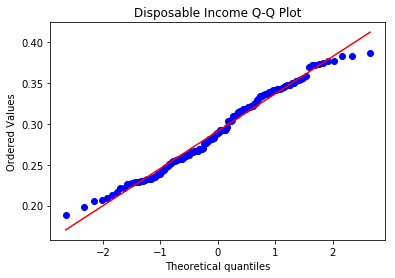

In [37]:
stats.probplot(hone['Disposable_Income'], plot= plt)
plt.title('Disposable Income Q-Q Plot')

After looking at Q-Q plot we can say that out distribution is normal enough. We are going to 

In [33]:
# Seperate the dataset to two different group with their characteristic
more_df = df[df.MoreThanMean == 1]
less_df = df[df.MoreThanMean == 0]

/Users/kaanbursa/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


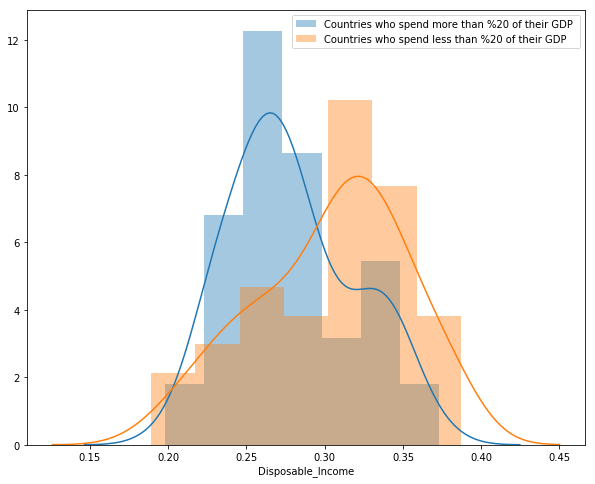

In [34]:
plt.figure(figsize=(10,8))
sns.distplot(more_df['Disposable_Income'],label='Countries who spend more than %20 of their GDP ')
sns.distplot(less_df['Disposable_Income'],label='Countries who spend less than %20 of their GDP')
plt.legend()